# Extract string angle from handle image

In [30]:
import numpy as np
import imutils
import cv2
import cv2.aruco as aruco
from numpy.linalg import norm
import math


In [37]:
# Video data
TEST_PATH = '/home/stmoon/Video/CarData3/20181102_163933.mp4'
# TEST_PATH = '/home/stmoon/Data/car/20181102_163625.mp4'
OUTPUT_PATH = 'data/out2/'
CAMERA_INFO = './camera.yaml'
OFFSET = -180
isSave = False
isDisplay = True

In [40]:
def attitude(rvec, tvec ):
    rvec_matrix = cv2.Rodrigues(rvec)[0]
    proj_matrix = np.hstack((rvec_matrix, tvec.T))
    eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6]
    
    yaw   = -eulerAngles[1]
    pitch =  eulerAngles[0]
    roll  =  eulerAngles[2]
    
    return roll, pitch, yaw

In [33]:
def tuningAngle__(angle) :
    angle = ( 720 + angle ) % 360
    return  angle + OFFSET

addition = 0 
def tuningAngle(prev_angle, angle) :
    global addition

    if prev_angle > 100  and angle  < -100 :
        addition += 360
    if prev_angle < -100 and angle > 100 :
        addition -= 360

    return  angle + addition + OFFSET

In [34]:
def handle2steering(handle) :
    return 0.0734*handle - 0.551

### search cross point of two lines 
- refer : http://www.gisdeveloper.co.kr/?p=89

- equation
![](http://www.gisdeveloper.co.kr/wp-content/uploads/1/884485.gif)

- parameter

![](http://www.gisdeveloper.co.kr/wp-content/uploads/1/267312.gif)

- 교점
![](http://www.gisdeveloper.co.kr/wp-content/uploads/1/656905.gif)


In [35]:
def centerMarker(corners) :
    p1 = corners[0][0][0]
    p2 = corners[0][0][2]
    p3 = corners[0][0][1]
    p4 = corners[0][0][3]
    
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    
    t = ((x4-x3)*(y1-y3)-(y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1)-(x4-x3)*(y2-y1))
    s = ((x2-x1)*(y1-y3)-(y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1)-(x4-x3)*(y2-y1))
    
    cx = x1 + s*(x2-x1)
    cy = y1 + s*(y2-y1)
    
    return (int(cx),int(cy))
    

In [42]:
cv_file = cv2.FileStorage(CAMERA_INFO, cv2.FILE_STORAGE_READ)

mtx = cv_file.getNode("camera_matrix").mat()
dist = cv_file.getNode("dist_coeff").mat()

cap = cv2.VideoCapture(TEST_PATH)

# video recorder
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter("output.avi", fourcc, 20, (1080, 1920))

# TEST: check roll
angle_list = []
    
prev_roll = 0
count = 0
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    
    # Rotate -90 
    frame = np.transpose(frame, axes=(1,0,2)).astype(np.uint8).copy() 
    frame = cv2.flip(frame, 1)
    
    # change image for gray image processing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)

    # aruco information
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_100)
    parameters =  aruco.DetectorParameters_create()  
    
    # lists of ids and the corners beloning to each id
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    cx,cy = 0,0
    # calculate attitude if marker is found.
    if np.all(ids == 2) :  
        rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners[0], 0.1, mtx, dist)        
        roll, pitch, yaw = attitude(rvec[0], tvec[0])
        tunangle = tuningAngle(prev_roll, roll)
        angle = handle2steering(tunangle)
        prev_roll = roll
        angle_list.append(tunangle)

        aruco.drawAxis(frame, mtx, dist, rvec[0], tvec[0], 0.01)
        aruco.drawDetectedMarkers(frame, corners)

        cx,cy = centerMarker(corners)
        
    else  :
        continue
    
    left = cx - 150
    top = cy - 1050
    width = 700
    height = 500

    # save the image (image_[num]_[angle].png)
    if isSave :
        crop_img =  frame[top:top+height, left:left+width]
        fn = OUTPUT_PATH + "/image_%04d_%.2f.png" % (count, angle)
        cv2.imwrite( fn, crop_img );

    # display image to save 
    if isDisplay :
        cv2.rectangle(frame,(left,top),(left+width,top+height),(0,0,255),3)    
        cv2.rectangle(frame,(cx,cy),(cx+10,cy+10),(0,0,255),3)
        
        # display steering angle
        str = "%f,%f"%(angle, tunangle)
#         print(str)
                                
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, str,(700,500), font, 1,(255,255,255),2,cv2.LINE_AA)
    
        # display the resulting frame
        #video_writer.write(frame)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
           break

    count += 1

# when everything done, release the capture
video_writer.release()
cap.release()
cv2.destroyAllWindows()



ValueError: axes don't match array

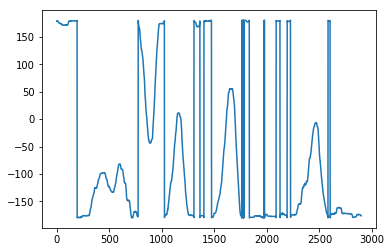

In [41]:
import matplotlib.pyplot as plt

plt.plot(angle_list)
plt.show()

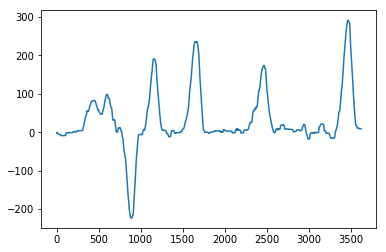

In [27]:
import matplotlib.pyplot as plt

addition = 0 
def tuningAngle1(prev_angle, angle) :
    global addition

    if prev_angle > 100  and angle  < -100 :
        addition += 360
    if prev_angle < -100 and angle > 100 :
        addition -= 360

    return  angle + addition + OFFSET

# print(angle_list[150:250])
angles = []
prev_a = 0
for a in angle_list :
    value = tuningAngle1(prev_a, a)
    angles.append(value)
    prev_a = a
    
plt.plot(angles)
plt.show()

In [218]:
-1 % 360


359